# Rocket League Notebook 1: EDA, Maps, and Cars

## Goals 

- Get familiar with Rocket League training data (and maybe testing data) related to maps and cars.
- Create a simple model based on maps and/or cars if EDA suggests there might be useful information there.

## Results

- The distribution of map usages among rankings is consistent with the overal distribution of rankings, so there's likely nothing predictive here.
- There's more variation in the car distributions, so I ran a logistical regression model using car names.

    - Used one hot encoding
    - Used Lasso feature selection
    - Accuracy is very low (0.26)

## Imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Converter

In [2]:
converter = { 'bronze': 1, 'silver': 2, 'gold': 3, 'platinum': 4, 'diamond': 5, 'champion': 6 }

## Read in and take a peak

In [3]:
train = pd.read_csv('../data/train.csv')

In [4]:
test = pd.read_csv('../data/test.csv')

In [5]:
train['rank'] = pd.Categorical(train['rank'], [
    "bronze",
    "silver",
    "gold",
    "platinum",
    "diamond",
    "champion"
])

Note from the head content below that each match has two rows, one for each player. Also, 91 columns is a lot of columns.

In [6]:
train.head()

,match_id,color,rank,map_code,duration,car_name,possession_time,time_in_side,shots,shots_against,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,0,blue,silver,neotokyo_standard_p,163,Breakout,54.95,58.96,2,4,...,62.736664,37.263340,66.84289,33.157120,95.53408,95.53408,95.53408,95.53408,1,0
1,0,orange,silver,neotokyo_standard_p,163,Octane,27.51,80.68,4,2,...,63.576576,36.423428,77.84667,22.153326,98.30417,98.30417,98.30417,98.30417,0,1
2,1,blue,gold,stadium_foggy_p,460,Octane,132.98,244.72,7,10,...,75.199120,24.800879,73.99232,26.007679,96.94244,96.94244,96.94244,96.94244,0,0
3,1,orange,gold,stadium_foggy_p,460,Octane,102.55,148.84,10,7,...,55.832005,44.167990,77.79280,22.207201,96.91851,96.91851,96.91851,96.91851,0,0
4,2,blue,silver,neotokyo_standard_p,94,Octane,25.24,33.70,0,3,...,76.376495,23.623503,68.45484,31.545156,93.63647,93.63647,93.63647,93.63647,0,0


## What proportion of players are in each rank level?

In [8]:
(train['rank'].value_counts().reset_index()
    .merge(
        train['rank'].value_counts(normalize=True).reset_index(), 
        on = 'index')
    .rename(columns = {'index':'rank', 'rank_x':'count', 'rank_y':'proportion'})
    .sort_values(by = 'rank')
)

,rank,count,proportion
5,bronze,1474,0.024468
4,silver,5680,0.094286
2,gold,12504,0.207563
0,platinum,14996,0.248929
1,diamond,13832,0.229607
3,champion,11756,0.195146


## Rocket League Questions

- Can assists be thrown out since these are H2H matchups?
- Are certain map codes or car names only unlocked once you reach a certain rank?
- Can these columns be grouped together, either with a multiindex or just a list?

### Can assists be thrown out since these are H2H matchups?

Yes, they can be thrown out. There are no assists.

In [9]:
train['assists'].unique()

array([0], dtype=int64)

### Are certain map codes or car names only unlocked once you reach a certain rank?

- The map codes distributions roughly match those of the ranks population.
- The cars might have a couple instances; however, the n is too small to be confident.

In [10]:
pd.crosstab(train['rank'], train['map_code']).sort_values(by = 'rank')


map_code,chn_stadium_p,cs_day_p,cs_p,eurostadium_night_p,eurostadium_p,eurostadium_rainy_p,farm_p,neotokyo_standard_p,park_night_p,park_p,...,stadium_foggy_p,stadium_p,trainstation_dawn_p,trainstation_night_p,trainstation_p,underwater_p,utopiastadium_dusk_p,utopiastadium_p,wasteland_night_s_p,wasteland_s_p
rank,,,,,,,,,,,,,,,,,,,,,
bronze,116,86,84,54,70,60,132,144,36,38,...,42,56,40,44,38,66,70,72,58,64
silver,500,298,338,260,278,166,480,478,190,198,...,202,214,132,166,134,272,238,234,262,260
gold,1222,698,754,524,556,412,1020,1026,370,400,...,398,530,338,392,302,520,490,576,516,566
platinum,1282,824,842,656,656,486,1222,1208,436,478,...,490,624,480,444,466,650,592,698,594,732
diamond,1220,872,692,574,616,490,1054,1184,442,388,...,432,658,376,372,412,566,602,574,558,660
champion,1000,654,620,502,552,440,926,1026,392,354,...,388,546,318,332,378,480,538,506,494,488


In [11]:
pd.crosstab(train['rank'], train['map_code'], normalize='columns').sort_values(by = 'rank')


map_code,chn_stadium_p,cs_day_p,cs_p,eurostadium_night_p,eurostadium_p,eurostadium_rainy_p,farm_p,neotokyo_standard_p,park_night_p,park_p,...,stadium_foggy_p,stadium_p,trainstation_dawn_p,trainstation_night_p,trainstation_p,underwater_p,utopiastadium_dusk_p,utopiastadium_p,wasteland_night_s_p,wasteland_s_p
rank,,,,,,,,,,,,,,,,,,,,,
bronze,0.021723,0.025058,0.025225,0.021012,0.025660,0.029211,0.027307,0.028425,0.019293,0.020474,...,0.021516,0.021309,0.023753,0.025143,0.021965,0.025842,0.027668,0.027068,0.023368,0.023105
silver,0.093633,0.086830,0.101502,0.101167,0.101906,0.080818,0.099297,0.094355,0.101822,0.106681,...,0.103484,0.081431,0.078385,0.094857,0.077457,0.106500,0.094071,0.087970,0.105560,0.093863
gold,0.228839,0.203380,0.226426,0.203891,0.203812,0.200584,0.211005,0.202527,0.198285,0.215517,...,0.203893,0.201674,0.200713,0.224000,0.174566,0.203602,0.193676,0.216541,0.207897,0.204332
platinum,0.240075,0.240093,0.252853,0.255253,0.240469,0.236611,0.252793,0.238452,0.233655,0.257543,...,0.251025,0.237443,0.285036,0.253714,0.269364,0.254503,0.233992,0.262406,0.239323,0.264260
diamond,0.228464,0.254079,0.207808,0.223346,0.225806,0.238559,0.218039,0.233715,0.236870,0.209052,...,0.221311,0.250381,0.223278,0.212571,0.238150,0.221613,0.237945,0.215789,0.224819,0.238267
champion,0.187266,0.190559,0.186186,0.195331,0.202346,0.214216,0.191560,0.202527,0.210075,0.190733,...,0.198770,0.207763,0.188836,0.189714,0.218497,0.187940,0.212648,0.190226,0.199033,0.176173


In [12]:
cars_ct_long = pd.crosstab(train['car_name'], train['rank'])
cars_ct_long[cars_ct_long['bronze']==0]


rank,bronze,silver,gold,platinum,diamond,champion
car_name,,,,,,
Aftershock,0,0,2,2,1,2
Artemis,0,0,0,2,0,0
DeLorean Time Machine,0,3,12,11,2,8
Ecto-1,0,1,2,0,1,0
Fast 4WD,0,0,1,5,7,2
Gazella GT,0,0,0,0,1,5
Guardian,0,1,0,0,2,0
Guardian G1,0,0,4,8,2,1
Jurassic Jeep® Wrangler,0,4,5,5,0,1


In [13]:
cars_ct_long_norm = pd.crosstab(train['car_name'], train['rank'], normalize='index')
cars_ct_long_norm[cars_ct_long_norm['bronze']==0]


rank,bronze,silver,gold,platinum,diamond,champion
car_name,,,,,,
Aftershock,0.0,0.000000,0.285714,0.285714,0.142857,0.285714
Artemis,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
DeLorean Time Machine,0.0,0.083333,0.333333,0.305556,0.055556,0.222222
Ecto-1,0.0,0.250000,0.500000,0.000000,0.250000,0.000000
Fast 4WD,0.0,0.000000,0.066667,0.333333,0.466667,0.133333
Gazella GT,0.0,0.000000,0.000000,0.000000,0.166667,0.833333
Guardian,0.0,0.333333,0.000000,0.000000,0.666667,0.000000
Guardian G1,0.0,0.000000,0.266667,0.533333,0.133333,0.066667
Jurassic Jeep® Wrangler,0.0,0.266667,0.333333,0.333333,0.000000,0.066667


### Lasso for feature selection from car names, i.e., Finding influential car names

In [14]:
preX = LabelEncoder().fit_transform(train['car_name'])

In [15]:
X = train[['car_name']]
y = train[['rank']]

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, random_state=42)

onehot = OneHotEncoder(handle_unknown = 'ignore')

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}
logreg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
gs_model = GridSearchCV(logreg, param)

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('gs_model', gs_model)
])

pipeline.fit(X_train_0, y_train_0.values.ravel())

best_params = pipeline['gs_model'].best_params_

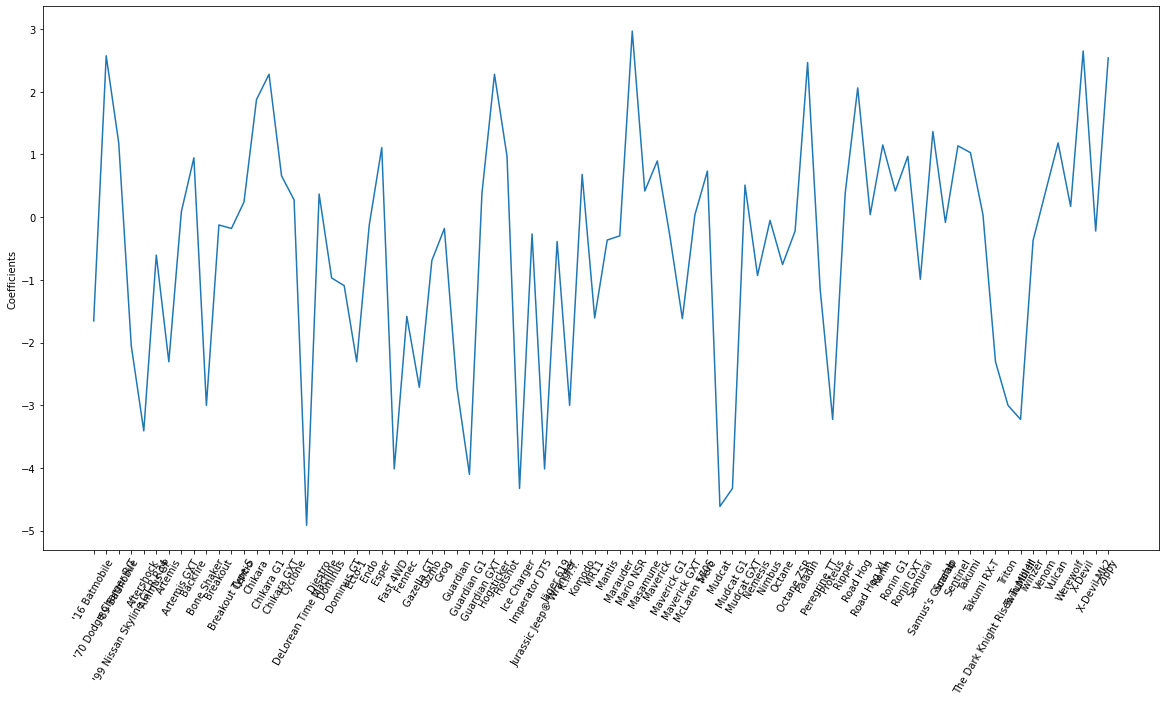

In [16]:
logreg = LogisticRegression(**best_params, penalty = 'l1', solver = 'liblinear')

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('logreg', logreg)
])

pipeline.fit(X_train_0, y_train_0.values.ravel())
coefs = pipeline['logreg'].coef_[0]

car_cols = pd.get_dummies(train['car_name']).columns

plt.subplots(figsize = (20, 10))
_ = plt.plot(range(len(car_cols)), coefs)
_ = plt.xticks(range(len(car_cols)), car_cols, rotation = 60)
_ = plt.ylabel('Coefficients')
plt.show()

### A no-good, very bad model using "relevant" car names and logistic regression

In [17]:
relevant_cars = pd.get_dummies(train['car_name']).columns[coefs != 0]
X = train.loc[train['car_name'].isin(relevant_cars), ['car_name']]
y = train.loc[train['car_name'].isin(relevant_cars), ['rank']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

onehot = OneHotEncoder(handle_unknown='ignore')

logreg = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('logreg', logreg)
])

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.25728703273355025
[[  14    0  219   57   51   22]
 [   1    9 2592   67  312    9]
 [   4    4 2801  150  433   11]
 [  11    0 2242  405  431   56]
 [   4    2 2846  289  587   48]
 [  13    2  891  201  218   59]]
              precision    recall  f1-score   support

      bronze       0.30      0.04      0.07       363
    champion       0.53      0.00      0.01      2990
     diamond       0.24      0.82      0.37      3403
        gold       0.35      0.13      0.19      3145
    platinum       0.29      0.16      0.20      3776
      silver       0.29      0.04      0.07      1384

    accuracy                           0.26     15061
   macro avg       0.33      0.20      0.15     15061
weighted avg       0.34      0.26      0.18     15061



In [18]:
pipeline.fit(X, y.values.ravel())
tester = test[['car_name']]

y_pred = pipeline.predict(tester)

y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})

In [22]:
submission = submission.drop_duplicates(subset = 'match_id')

In [23]:
submission.to_csv('../submissions/submission_2022-03-24_v1.csv', index = False)

### That didn't go very well. For good measure, here is a KNN model using the relevant car names. This model is actually worse on a relatively small number of neighbors.

In [ ]:
relevant_cars = X_train_0.columns[coefs != 0]
X = pd.get_dummies(train.loc[train['car_name'].isin(relevant_cars), 'car_name'])
y = train.loc[train['car_name'].isin(relevant_cars), 'rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### One more stab with the car names, this time tuning the n_neighbors hyperparameter.

In [ ]:
relevant_cars = X_train_0.columns[coefs != 0]
X = pd.get_dummies(train.loc[train['car_name'].isin(relevant_cars), 'car_name'])
y = train.loc[train['car_name'].isin(relevant_cars), 'rank']

knn = KNeighborsClassifier()

neighbor_space = np.arange(3, 50)
params = {'n_neighbors':neighbor_space}
grid_search = GridSearchCV(knn, params, cv = 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_search.fit(X_train, y_train)

grid_search.best_params_


In [ ]:
best_neighbors_cars = grid_search.best_params_
knn = KNeighborsClassifier(**best_neighbors_cars)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
best_neighbors_cars = grid_search.best_params_
knn = KNeighborsClassifier(**best_neighbors_cars)

knn.fit(X, y)
y_pred = knn.predict(X)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

In [ ]:
knn.predict(pd.get_dummies(test['car_name'], ))

## Try one more with a tree classifier

In [25]:
relevant_cars = pd.get_dummies(train['car_name']).columns[coefs != 0]
X = train.loc[train['car_name'].isin(relevant_cars), ['car_name']]
y = train.loc[train['car_name'].isin(relevant_cars), ['rank']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

onehot = OneHotEncoder(handle_unknown='ignore')

dt = DecisionTreeClassifier()

pipeline = Pipeline(steps=[
    ('onehot', onehot),
    ('dt', dt)
])

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.25695504946550696
[[  21    0  220   49   51   22]
 [   2    9 2592   66  312    9]
 [   5    5 2802  148  432   11]
 [  22    0 2244  394  429   56]
 [  13    2 2849  279  585   48]
 [  18    2  891  195  219   59]]
              precision    recall  f1-score   support

      bronze       0.26      0.06      0.09       363
    champion       0.50      0.00      0.01      2990
     diamond       0.24      0.82      0.37      3403
        gold       0.35      0.13      0.18      3145
    platinum       0.29      0.15      0.20      3776
      silver       0.29      0.04      0.07      1384

    accuracy                           0.26     15061
   macro avg       0.32      0.20      0.16     15061
weighted avg       0.33      0.26      0.18     15061

